Wizualizacja danych

In [1]:
import matplotlib.pyplot as plt
import json
import numpy as np
# import pandas as pd
# import seaborn as sns
import os
# from filtr_json_from_race import filtr_json_files


In [42]:
def filtr_json_files(telem_file_raw, scoring_file_raw):
    data_telem = json.load(open(telem_file_raw ))
    data_scoring = json.load(open(scoring_file_raw))
    raw_data_telemetry = []
    raw_data_scoring = []

    filtered_data_scoring = []
    filtered_data_telemetry = []
    for entry in data_telem:
        if entry.get("Type") == "TelemInfoV01":
            raw_data_telemetry.append(entry)
    for entry in data_scoring:
        if entry.get("Type") == "ScoringInfoV01":
            raw_data_scoring.append(entry)

    # with open("data/telemetry_data_filtered.json", "w") as f:
    #     json.dump(filtered_data, f, indent=2)
    scoring_records_len = 0
    data_before_start = 0
    start_flag = False

    for entry in raw_data_scoring:
        # for vehicle in raw_data_scoring.get("mVehicles", []):
        start = entry["mStartLight"]
        if start == 0 and not start_flag:
            data_before_start += 1
            start_flag = True
            continue

        #     if vehicle.get("mIsPlayer"):
        vehicle = entry.get("mVehicles")

        wanted_weather_keys = ["mRaining","mAmbientTemp","mTrackTemp","mEndET", "mCurrentET"]
        subset_weather = {k: entry.get(k) for k in wanted_weather_keys}
        subset_weather["mTotalLapDistance"] = entry["mLapDist"]
        
        
        vehicle_sector = vehicle[0]["mSector"]
        
        curr_sector = vehicle_sector
        wanted_keys = ["mLastLapTime","mBestLapTime","mCurrLapTime","mNumPitstops","mNumPenalties","mInPits","mFinishStatus","mLapDist","mSector"]
        if vehicle[0]["mFinishStatus"] == 1:
            subset_scoring_vehicle = {k: vehicle[0].get(k) for k in wanted_keys}

        # print(json.dumps(vehicle, indent=2))
        # scoring_records.append(data)
            filtered_data_scoring.append({**subset_scoring_vehicle, **subset_weather})
            scoring_records_len += 1

            break

        subset_scoring_vehicle = {k: vehicle[0].get(k) for k in wanted_keys}

        # print(json.dumps(vehicle, indent=2))
        # scoring_records.append(data)
        filtered_data_scoring.append({**subset_scoring_vehicle, **subset_weather})
        scoring_records_len += 1
    
    telemetry_records_len = 0
    count_before_start = 0
    for entry in raw_data_telemetry:
        if count_before_start < data_before_start:
            count_before_start += 1
            continue
        if telemetry_records_len >= scoring_records_len:
            break
        wanted_keys = ["mFuel", "mFuelCapacity","mWheel","mDentSeverity","mFrontTireCompoundIndex","mCurrentSector","mLapNumber"]


        subset = {k: entry.get(k) for k in wanted_keys}

        # subset["mWheel"] = [
        #         {
        #             "mWear": wheel.get("mWear"),
        #             "mBrakeTemp": wheel.get("mBrakeTemp"),
        #             "mTemperature": wheel.get("mTemperature"),
        #         }
        #         for wheel in entry.get("mWheel", [])
        #     ]
        wheels = entry.get("mWheel", [])
        avg_wear = 0
        avg_brake_temp = 0
        avg_temp = 0
        for wheel in wheels:
            avg_wear += wheel.get("mWear", 0)
            # avg_brake_temp += wheel.get("mBrakeTemp", 0)
            # avg_temp += wheel.get("mTemperature", 0)
            for temp in wheel.get("mTemperature", 0):
                avg_temp += temp
            avg_temp /= len(wheel.get("mTemperature", []))
        avg_wear /= len(wheels)
        # avg_brake_temp /= len(wheels)
        avg_temp /= len(wheels)

        subset["mWheel"] = {
            "mWear": avg_wear,
            "mBrakeTemp": avg_brake_temp,
            "mTemperature": avg_temp,
        }
        filtered_data_telemetry.append(subset)
        telemetry_records_len += 1
        # print(json.dumps(subset, indent=2))
    

    return filtered_data_telemetry, filtered_data_scoring

In [43]:
scoring_file_raw = "E:/pracadyp/Race-optimization-reinforcement-learning/data/raw_races/scoring_data_x310min.json"
telem_file_raw = "E:/pracadyp/Race-optimization-reinforcement-learning/data/raw_races/telemetry_data_x310min.json"



In [44]:
filtered_data_telemetry, filtered_data_scoring = filtr_json_files(telem_file_raw, scoring_file_raw)
print(f"len filtered_data_telemetry: {len(filtered_data_telemetry)}")
print(filtered_data_telemetry[0])
print(filtered_data_scoring[0])
a = 0  

len filtered_data_telemetry: 1761
{'mFuel': 88.6789221910379, 'mFuelCapacity': 110.0, 'mWheel': {'mWear': 0.9994760155677795, 'mBrakeTemp': 0, 'mTemperature': 117.26972188415687}, 'mDentSeverity': [0, 0, 0, 0, 0, 0, 0, 0], 'mFrontTireCompoundIndex': 0, 'mCurrentSector': 2, 'mLapNumber': 0}
{'mLastLapTime': 0.0, 'mBestLapTime': -1.0, 'mCurrLapTime': None, 'mNumPitstops': 0, 'mNumPenalties': 0, 'mInPits': False, 'mFinishStatus': 0, 'mLapDist': 13346.13671875, 'mSector': 0, 'mRaining': 0.0, 'mAmbientTemp': 17.999637329732366, 'mTrackTemp': 42.99999389621945, 'mEndET': -2147483648.0, 'mCurrentET': 125.8, 'mTotalLapDistance': 13623.9677734375}


Fuel

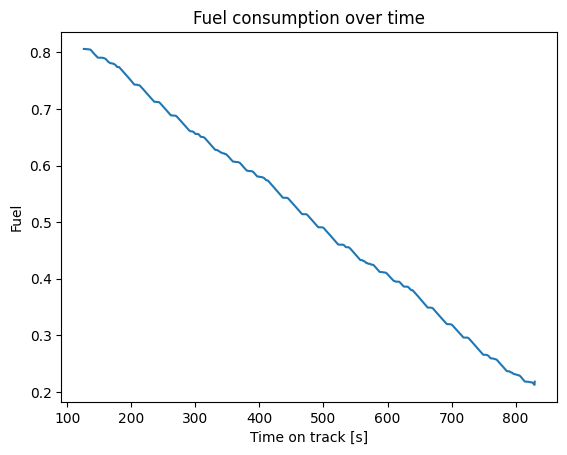

In [45]:
plt.plot([entry["mCurrentET"] for entry in filtered_data_scoring], [entry["mFuel"]/entry["mFuelCapacity"] for entry in filtered_data_telemetry])

plt.xlabel("Time on track [s]")
plt.ylabel("Fuel")
plt.title("Fuel consumption over time")
plt.show()


Wheels wear

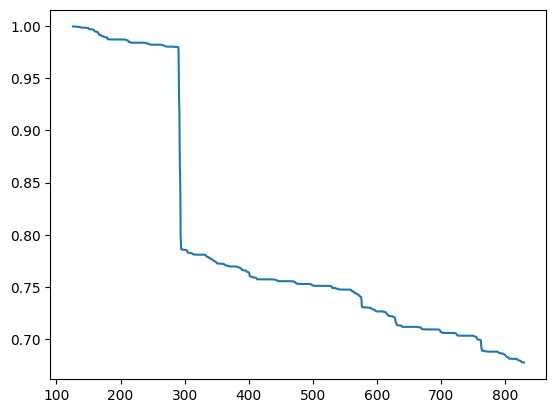

In [46]:
plt.plot([entry["mCurrentET"] for entry in filtered_data_scoring], [entry["mWheel"]["mWear"] for entry in filtered_data_telemetry])

Czas ostatniego okrążenia

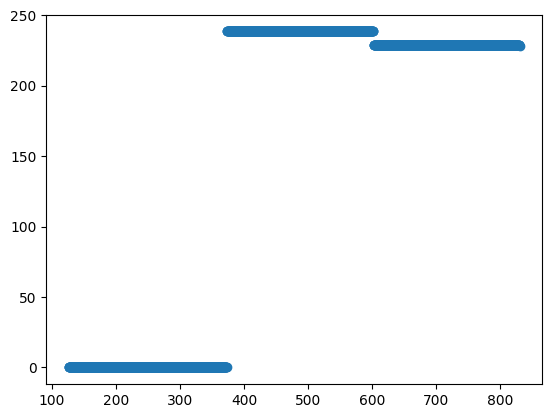

In [47]:
plt.scatter([entry["mCurrentET"] for entry in filtered_data_scoring], [entry["mLastLapTime"] for entry in filtered_data_scoring])

Uszkodzenia pojazd podczas wyścigu

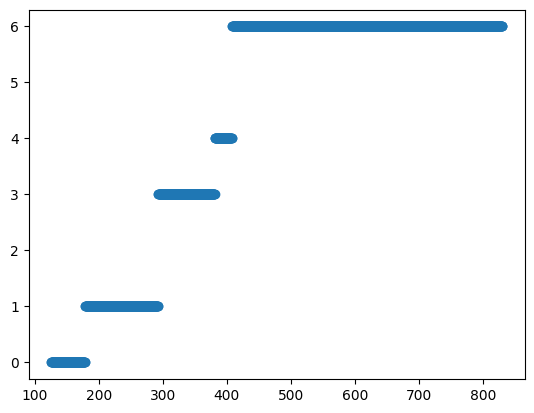

In [48]:
# dent = [entry["mDentSeverity"] for entry in filtered_data_telemetry]


plt.scatter([entry["mCurrentET"] for entry in filtered_data_scoring], [sum(entry["mDentSeverity"]) for entry in filtered_data_telemetry])

Procent przejechanego okrążenia z podziałem na sektory

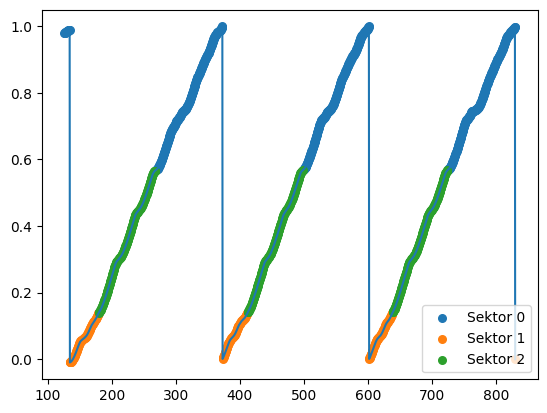

In [49]:
plt.plot(
    [entry["mCurrentET"] for entry in filtered_data_scoring],
    [entry["mLapDist"]/entry["mTotalLapDistance"] for entry in filtered_data_scoring]
)

# Dodaj znaczniki dla każdego sektora
for sector in [0, 1, 2]:
    sector_times = [entry["mCurrentET"] for entry in filtered_data_scoring if entry["mSector"] == sector]
    sector_progress = [entry["mLapDist"]/entry["mTotalLapDistance"] for entry in filtered_data_scoring if entry["mSector"] == sector]
    plt.scatter(sector_times, sector_progress, label=f"Sektor {sector}", s=30)

plt.legend()
plt.show()
